# 📚 Libraries 

In [1]:
%pip install --quiet imbalanced-learn --upgrade
%pip install --quiet scikit-plot
%pip install --quiet xgboost --upgrade
%pip install --quiet pickle

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import warnings
import pickle
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
%matplotlib inline

In [3]:
stroke = pd.read_csv("stroke_dataset.csv")
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
stroke.shape

(5110, 12)

In [5]:
stroke.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

# 🔎 DATA UNDERSTANDING

### Exploratory Data Analysis (EDA)

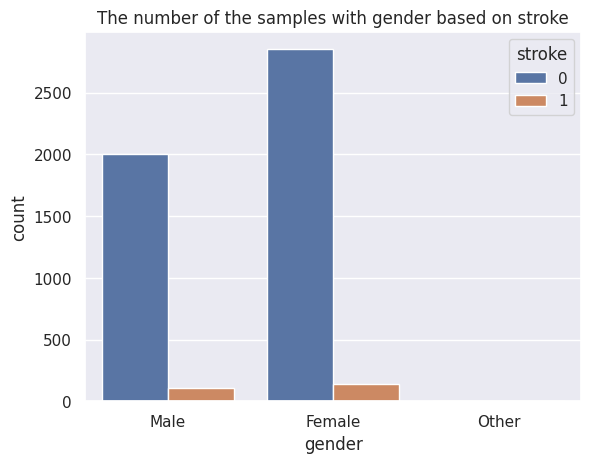

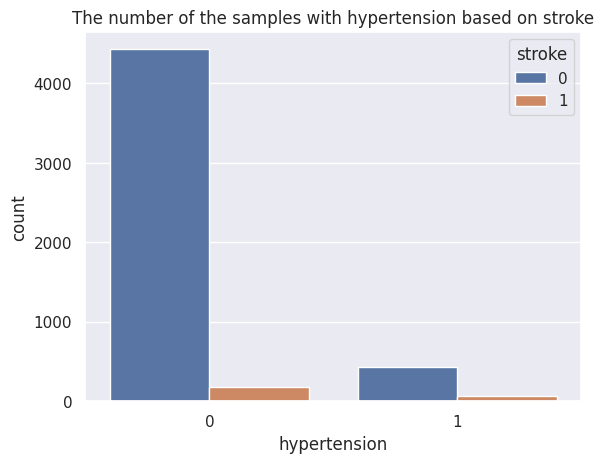

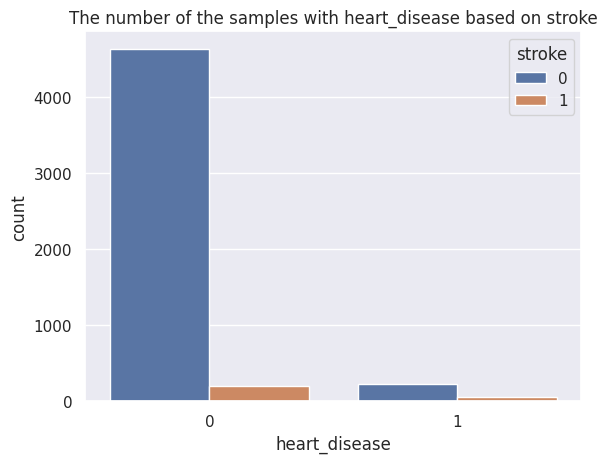

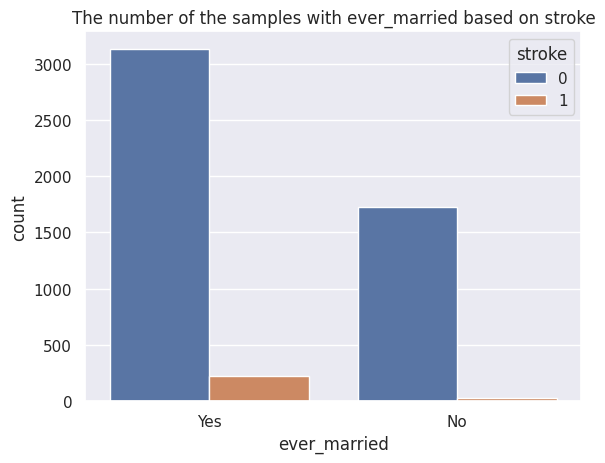

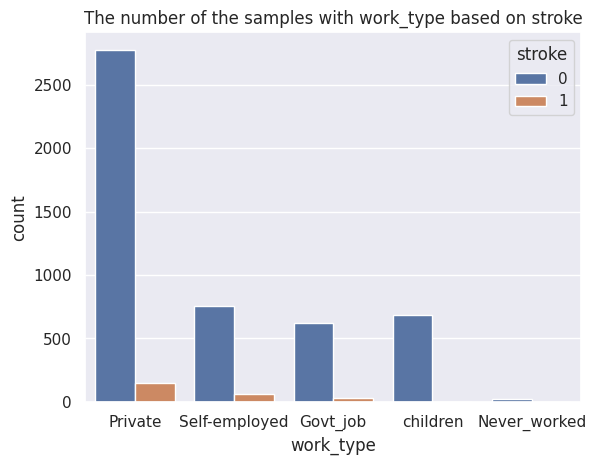

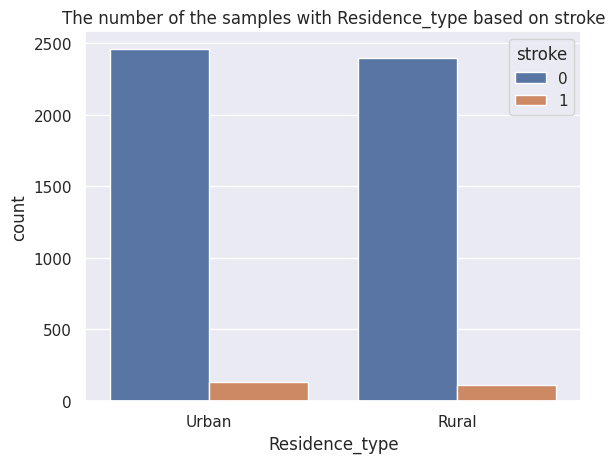

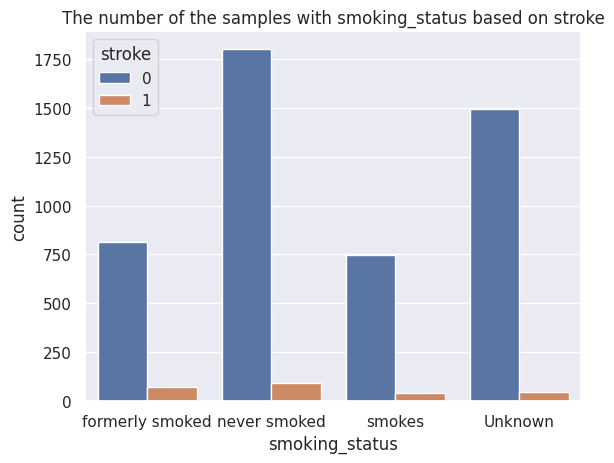

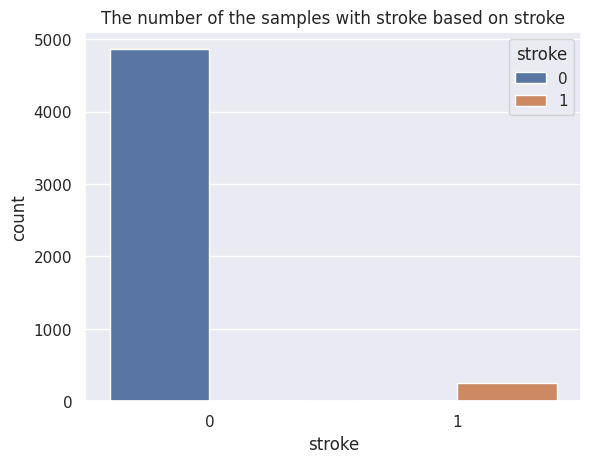

In [6]:
sns.set_theme(style = 'darkgrid')
for i in stroke.columns[1:]:
    if (stroke[i].dtype == 'object') or (stroke[i].dtype == 'int64'):
            sns.countplot(data = stroke, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

#Stroke data is imbalanced, this require further explanation

/tmp/ipykernel_84/2683853317.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(stroke[stroke['stroke'] == 0]['bmi'],color='green')
/tmp/ipykernel_84/2683853317.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(stroke[stroke['stroke'] == 1]['bmi'],color='red')


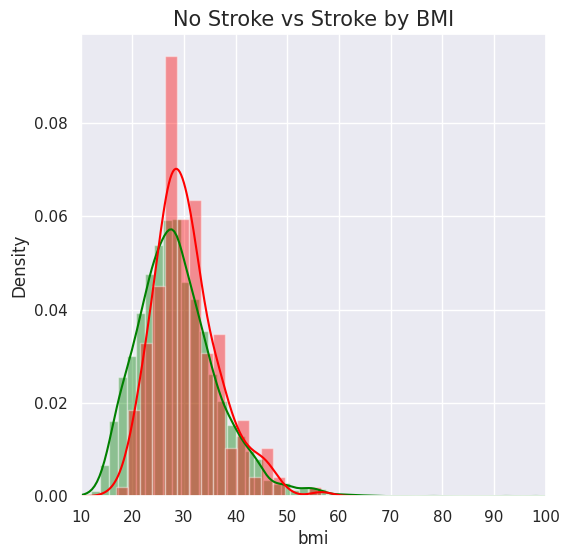

In [7]:
plt.figure(figsize=(6, 6))
sns.distplot(stroke[stroke['stroke'] == 0]['bmi'],color='green')
sns.distplot(stroke[stroke['stroke'] == 1]['bmi'],color='red')

plt.title('No Stroke vs Stroke by BMI',fontsize=15)
plt.xlim([10,100])

warnings.filterwarnings("ignore")

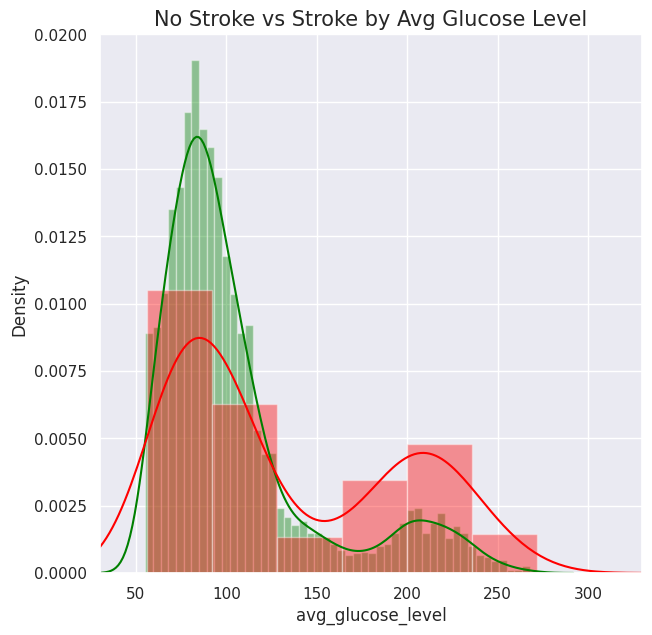

In [8]:
plt.figure(figsize=(7,7))
sns.distplot(stroke[stroke['stroke'] == 0]['avg_glucose_level'],color='green')
sns.distplot(stroke[stroke['stroke'] == 1]['avg_glucose_level'],color='red')
plt.title('No Stroke vs Stroke by Avg Glucose Level',fontsize=15)
plt.xlim([30,330])

warnings.filterwarnings("ignore")

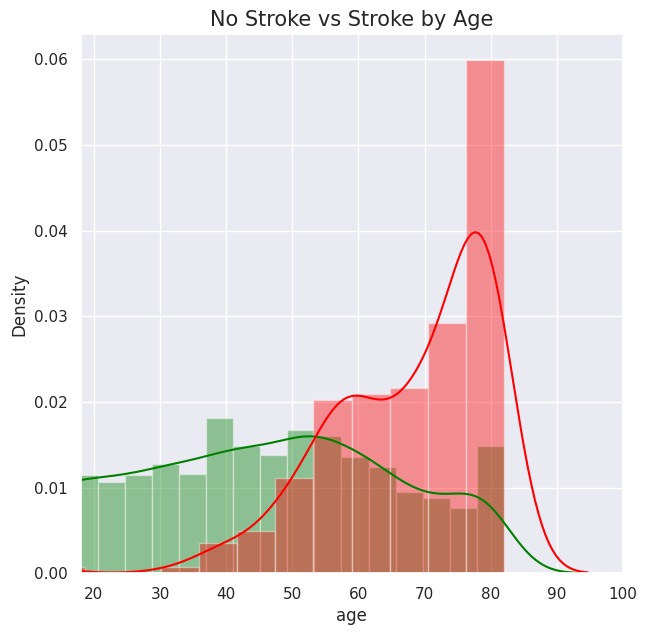

In [9]:
plt.figure(figsize=(7,7))
sns.distplot(stroke[stroke['stroke'] == 0]['age'],color='green')
sns.distplot(stroke[stroke['stroke'] == 1]['age'],color='red')
plt.title('No Stroke vs Stroke by Age',fontsize=15)
plt.xlim([18,100])

warnings.filterwarnings("ignore")

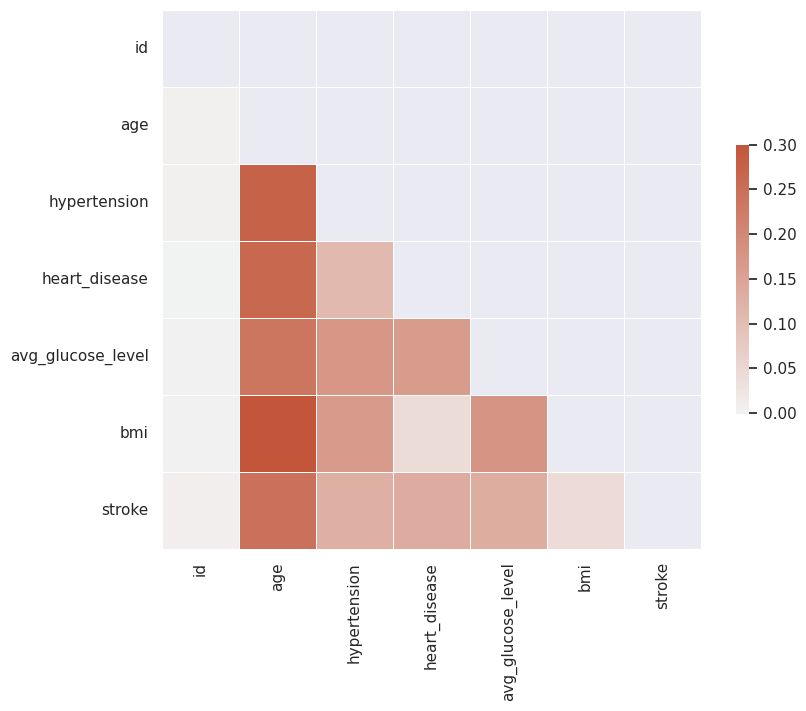

In [10]:
corr = stroke.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
f, ax = plt.subplots(figsize=(9,7))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={'shrink':.5})

warnings.filterwarnings("ignore")

# 🧹 DATA PREPARATION

### Remove Null Data

In [11]:
# Check null
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
#Drop All Null
stroke.dropna(inplace=True)
stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Remove Data Outliers

Outliers are being removed using IQR methodology, data that outside the range of Q1 - Q3 are being eliminated.

In [13]:
print("Shape before filter: ", stroke.shape)

Shape before filter:  (4909, 12)


In [14]:
q1 = stroke['bmi'].quantile(0.25)
q3 = stroke['bmi'].quantile(0.75)

IQR = q3 - q1
stroke = stroke [~( (stroke['bmi'] < (q1-1.5*IQR))| (stroke['bmi'] > (q3+1.5*IQR)))]

print("Shape after filter: ", stroke.shape)

Shape after filter:  (4799, 12)


### Features and Target Data Separation

In [15]:

X = stroke.iloc[:, 1:-1]
y = stroke.iloc[:, -1]
y.head()

0    1
2    1
3    1
4    1
5    1
Name: stroke, dtype: int64

In [17]:
#Encode Label Column
#Cols needed to be encode: 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
# Export the encoder

encoders = {}
cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoders, f)

X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.6,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2
3,0,49.0,0,0,1,2,1,171.23,34.4,3
4,0,79.0,1,0,1,3,0,174.12,24.0,2
5,1,81.0,0,0,1,2,1,186.21,29.0,1


### Oversampling Minority Class

0    4592
1     207
Name: stroke, dtype: int64


<AxesSubplot: >

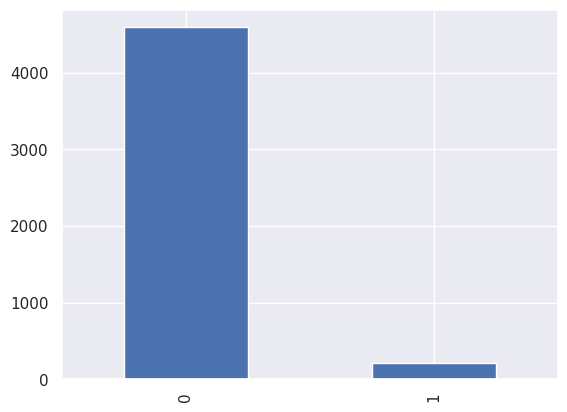

In [18]:
print(y.value_counts())
y.value_counts().sort_index().plot.bar()

0    4592
1    4592
Name: stroke, dtype: int64


<AxesSubplot: >

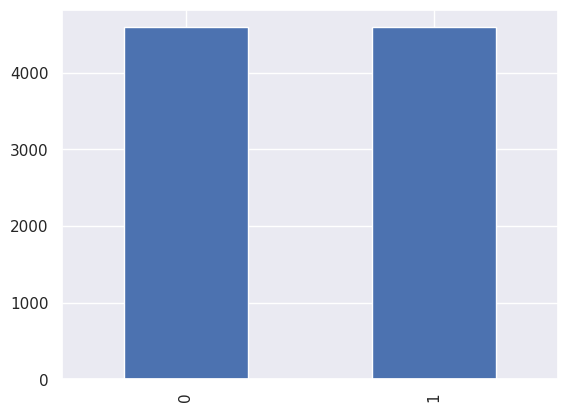

In [19]:
#Oversampling 
sample = SMOTE()
X, y = sample.fit_resample(X, y)

print(y.value_counts())
y.value_counts().sort_index().plot.bar()

### Train and Test Splitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Normalize Data

In [37]:
#Normalize data

minMax = MinMaxScaler().fit(X)
with open('scaler.pickle', 'wb') as f:
    pickle.dump(minMax, f)
X_train = minMax.transform(X_train)
X_test = minMax.transform(X_test)
X_train

array([[ 0.        ,  0.00688212,  0.        , ..., -0.25429805,
        -0.26278599,  0.        ],
       [ 0.25      ,  0.00452495,  0.        , ..., -0.2531103 ,
        -0.26774788,  0.        ],
       [ 0.25      ,  0.00884628,  0.        , ..., -0.25343422,
        -0.26069328,  0.22222222],
       ...,
       [ 0.        , -0.00069046,  0.        , ..., -0.25422379,
        -0.27064397,  0.        ],
       [ 0.        ,  0.00997099,  0.        , ..., -0.25409408,
        -0.26098895,  0.22222222],
       [ 0.        ,  0.00214076,  0.        , ..., -0.25370807,
        -0.26381215,  0.33333333]])

# 🖧 MODELLING 

### Evaluation Function

In [40]:
#Print Function

def printAcc(y_pred):
    print("CLASSIFICATION REPORT: \n", classification_report(y_test, y_pred))
    print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred)*100, "%")
    print("RECALL SCORE: ", recall_score(y_test, y_pred)*100, "%")
    print("F-MEASURE SCORE: ", f1_score(y_test, y_pred)*100, "%")

    skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), cmap='YlGnBu')
    # Roc Curve
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    sns.set_theme(style = 'white')
    plt.figure(figsize = (8, 8))
    plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


## KNN

Lowest Error rate is at index: 1 with value of  0.09090909090909091


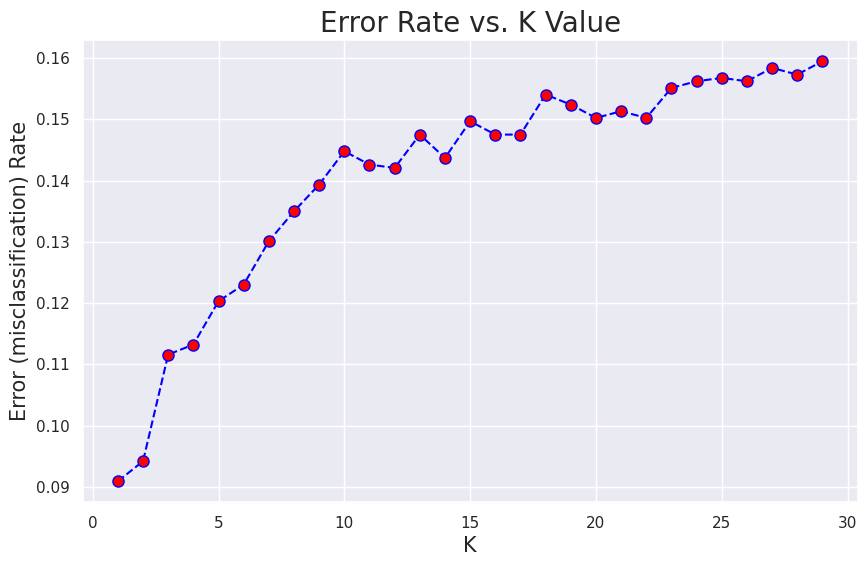

In [23]:
#----------------KNN------------------
#Finding lowest Error rate
error_rate  = []

for i in range(1, 30):
    classifier = KNeighborsClassifier(n_neighbors= i)
    classifier.fit(X_train, y_train)
    y_pred_i = classifier.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))
    
plt.figure(figsize = (10, 6))
plt.plot(range(1,30), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K', fontsize=15)
plt.ylabel('Error (misclassification) Rate', fontsize=15) 

lowest_err_index = error_rate.index( min(error_rate)) + 1
print("Lowest Error rate is at index:", lowest_err_index, "with value of ",  min(error_rate))

{'n_neighbors': 2, 'weights': 'distance'}
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       944
           1       0.87      0.95      0.91       893

    accuracy                           0.91      1837
   macro avg       0.91      0.91      0.91      1837
weighted avg       0.91      0.91      0.91      1837

ACCURACY SCORE:  90.9090909090909 %
RECALL SCORE:  94.96080627099664 %
F-MEASURE SCORE:  91.03596349973162 %


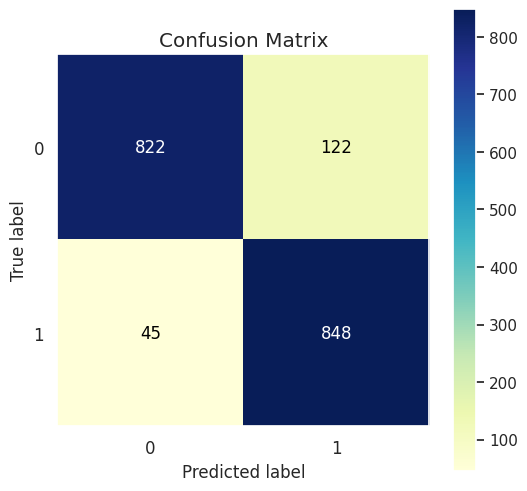

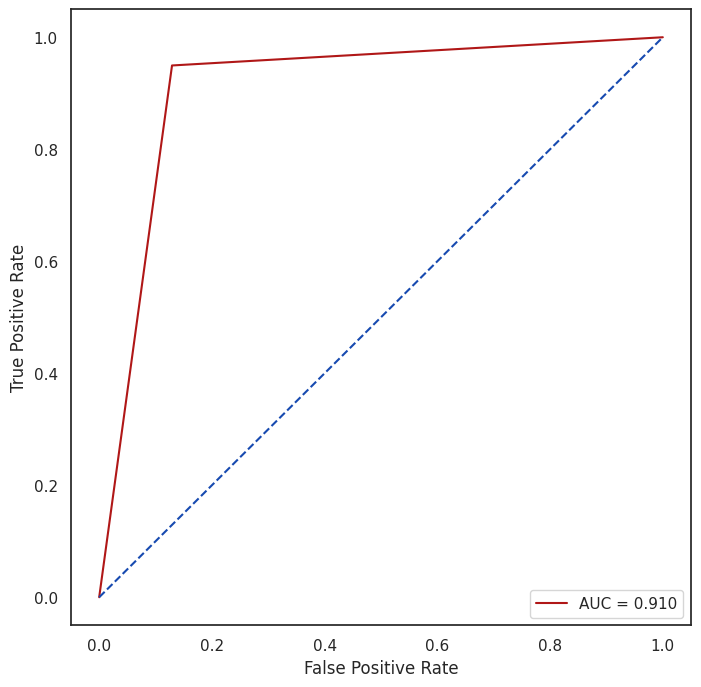

In [24]:
#Model Creationv

param_grid = {
    'n_neighbors': [2, 3, 4, 5],  # Adjust the values of k (number of neighbors) to be searched
    'weights': ['uniform', 'distance']  # Adjust the weight options to be searched
}

# Create an instance of the KNN classifier
knnModel = KNeighborsClassifier()

# Create a GridSearchCV object with the classifier and parameter grid
best_knnModel = GridSearchCV(knnModel, param_grid, cv=3, scoring='accuracy')  # Adjust the scoring metric if needed

# Fit the GridSearchCV object to the training data
best_knnModel.fit(X_train, y_train)

# Get the best estimator and its corresponding parameters
best_estimator = best_knnModel.best_estimator_
best_params = best_knnModel.best_params_

print(best_params)

# Train the model using the best estimator
best_estimator.fit(X_train, y_train)

# Make predictions on the test set using the best estimator
y_pred_knn = best_estimator.predict(X_test)

# Measure Accuracy
printAcc(y_pred_knn)

## SVM

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.88      0.83      0.86       944
           1       0.83      0.88      0.86       893

    accuracy                           0.86      1837
   macro avg       0.86      0.86      0.86      1837
weighted avg       0.86      0.86      0.86      1837

ACCURACY SCORE:  85.57430593358737 %
RECALL SCORE:  88.46584546472565 %
F-MEASURE SCORE:  85.6368563685637 %


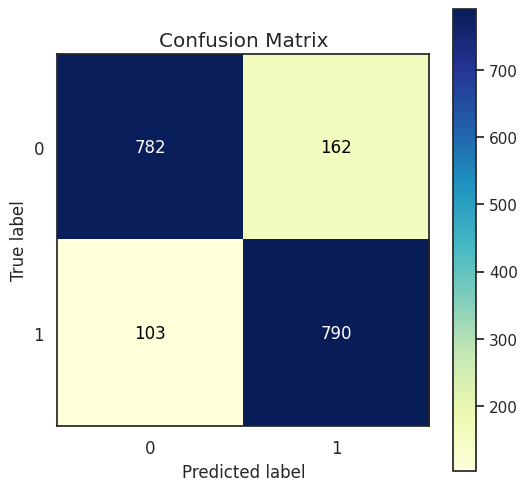

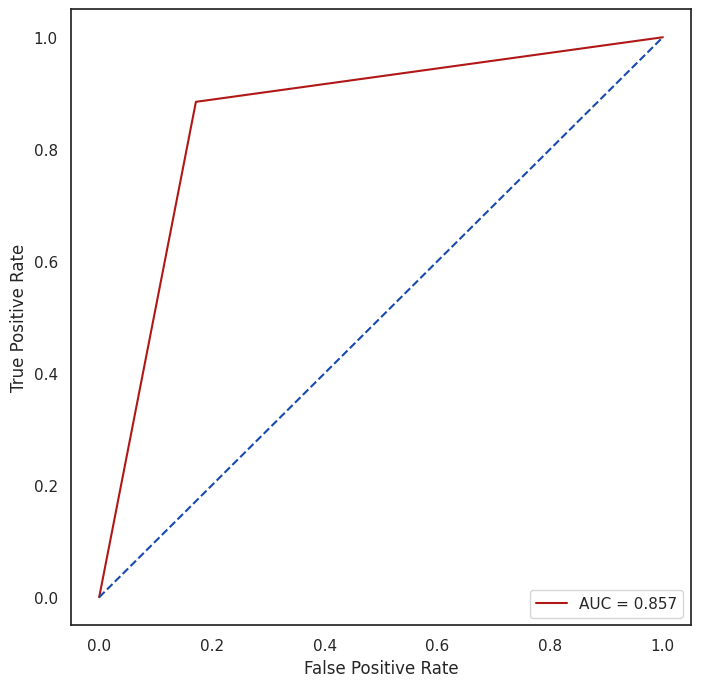

In [25]:
param_grid = {
    'C': [0.1, 1, 10],  # Adjust the values of the regularization parameter C to be searched
    'kernel': ['linear', 'rbf'],  # Adjust the kernel options to be searched
    'gamma': ['scale', 'auto']  # Adjust the gamma options to be searched
}

# Create an instance of the SVM classifier
svmModel = svm.SVC()

# Create a GridSearchCV object with the classifier and parameter grid
best_svmModel = GridSearchCV(svmModel, param_grid, cv=3, scoring='accuracy')  # Adjust the scoring metric if needed

# Fit the GridSearchCV object to the training data
best_svmModel.fit(X_train, y_train)

# Get the best estimator and its corresponding parameters
best_estimator = best_svmModel.best_estimator_
best_params = best_svmModel.best_params_

print(best_params)

# Train the model using the best estimator
best_estimator.fit(X_train, y_train)

# Make predictions on the test set using the best estimator
y_pred_svm = best_estimator.predict(X_test)

# Measure Accuracy
printAcc(y_pred_svm)

## Decision Tree

{'criterion': 'entropy', 'max_depth': 15}
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       944
           1       0.89      0.92      0.91       893

    accuracy                           0.91      1837
   macro avg       0.91      0.91      0.91      1837
weighted avg       0.91      0.91      0.91      1837

ACCURACY SCORE:  90.80021774632553 %
RECALL SCORE:  92.38521836506159 %
F-MEASURE SCORE:  90.70918086860912 %


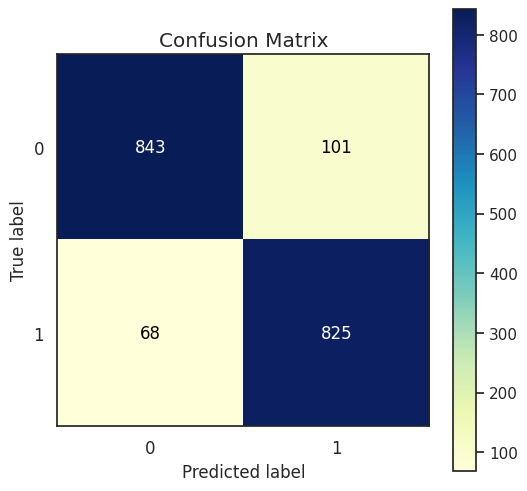

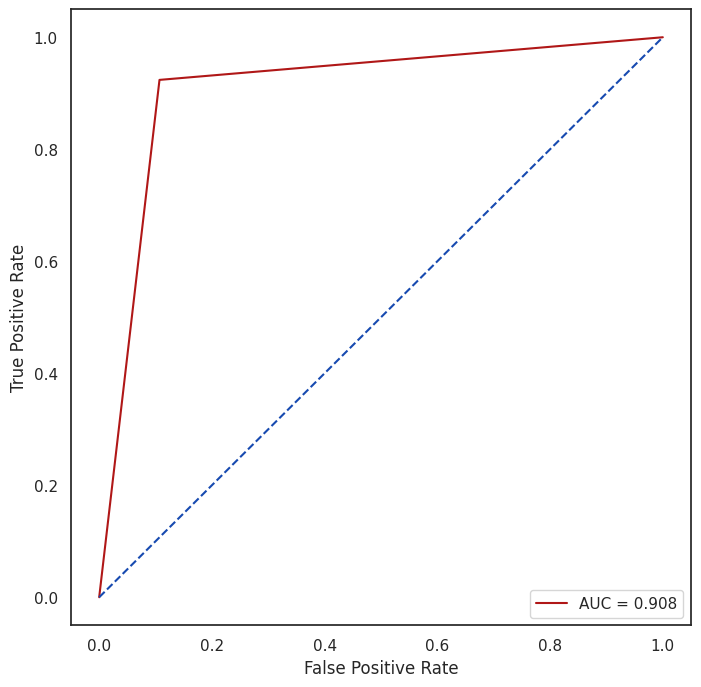

In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # Adjust the criterion options to be searched
    'max_depth': [5, 10, 15]  # Adjust the maximum depth values to be searched
}

treeModel = DecisionTreeClassifier()

# Create a GridSearchCV object with the classifier and parameter grid
grid_search = GridSearchCV(treeModel, param_grid, cv=3, scoring='accuracy')  # Adjust the scoring metric if needed

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and its corresponding parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_params)

# Train the model using the best estimator
best_estimator.fit(X_train, y_train)

# Make predictions on the test set using the best estimator
y_pred_tree = best_estimator.predict(X_test)

# Measure Accuracy
printAcc(y_pred_tree)

## XGBoost Classifier

In [31]:
X_test[0]

array([0.        , 0.97891452, 0.        , 0.        , 1.        ,
       0.5       , 0.        , 0.11310532, 0.33760277, 0.33333333])

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       944
           1       0.96      0.96      0.96       893

    accuracy                           0.96      1837
   macro avg       0.96      0.96      0.96      1837
weighted avg       0.96      0.96      0.96      1837

ACCURACY SCORE:  96.08056614044638 %
RECALL SCORE:  95.63269876819709 %
F-MEASURE SCORE:  95.95505617977528 %


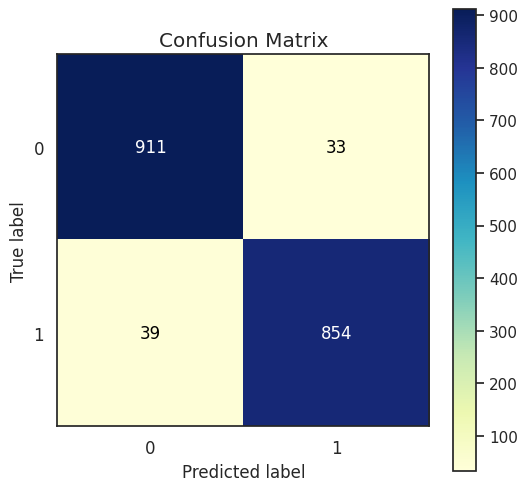

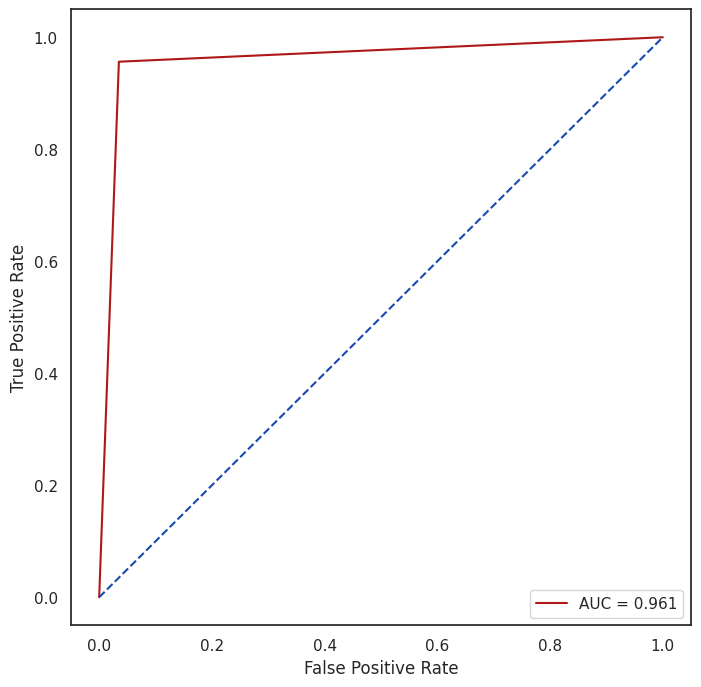

In [41]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],  
    'max_depth': [3, 4, 5],  
    'n_estimators': [100, 200, 300]  
}

xgbModel = XGBClassifier(objective='binary:logistic', random_state=0, eval_metric='mlogloss')


best_xgbModel = GridSearchCV(xgbModel, param_grid, cv=3, scoring='accuracy')  # Adjust the scoring metric if needed

# Fit the GridSearchCV object to the training data

best_xgbModel.fit(X_train, y_train)

# Get the best estimator and its corresponding parameters
best_estimator = best_xgbModel.best_estimator_
best_params = best_xgbModel.best_params_
print(best_params)

# Train the model using the best estimator
best_estimator.fit(X_train, y_train)

# Make predictions on the test set using the best estimator
y_pred_xgb = best_estimator.predict(X_test)

printAcc(y_pred_xgb)

# CONCLUSION

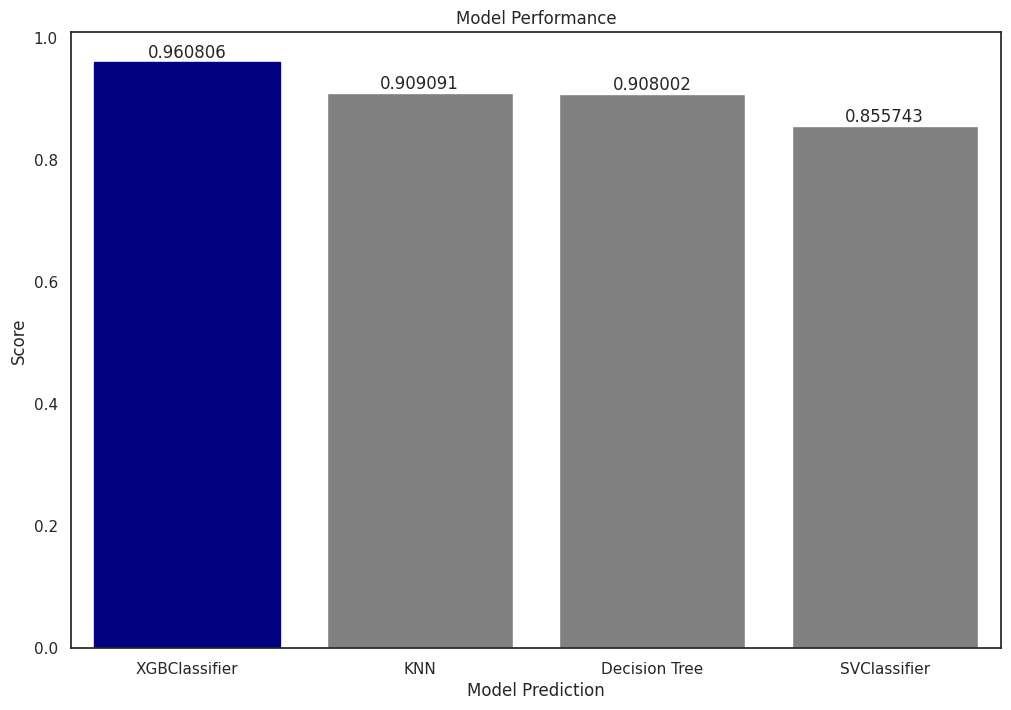

In [42]:
Performance = pd.DataFrame(
    data = {
        'Model Prediction': ['KNN','Decision Tree','SVClassifier', 'XGBClassifier'],
        'Score': [accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_tree), 
        accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_xgb)]
    }
)

Performance = Performance.sort_values(by='Score', ascending=False)

# Create the bar plot with highlighted highest value
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Model Prediction", y="Score", data=Performance, palette=["grey"] * len(Performance))
ax.bar_label(ax.containers[0])

# Highlight the highest value with a blue color
highest_score = Performance['Score'][0]
for i, p in enumerate(ax.patches):
    if Performance.loc[i, 'Score'] == highest_score:
        p.set_color('#000080')

plt.title("Model Performance")
plt.show()

# DEPLOYMENT

In [43]:
with open('best_xgbModel.pickle', 'wb') as f:
    pickle.dump(best_xgbModel, f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d7d8125-cc82-4e3e-b82e-f3b31c53b246' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>